# 本筆記內容：熟悉機器學習演算法基礎。

核心概念: 

1. 使用TensorFlow做誤差倒傳遞 (Backpropagation)。
2. 利用批次梯度下降法(Mini-batch Gradient Descent)實作線性迴歸。

我們希望讀者能透過此範例，來理解監督式機器學習的基本概念，包含：
   * 監督式機器學習即是最小化Loss函數。此範例中，Loss函數為Mean Square Error Loss。
   * 如何利用Mini-batch Gradient Descent更新權重。
   * 理解L1 (Lasso)的功用。

---

# <a name=00> 索引 </a>

[1. 以Gradient Tape來紀錄Gradients](#01)

[2. 資料型別: ```Variable``` and  ```constant```](#02)

[3. 線性迴歸](#03)

---

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import os

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

import numpy.typing as npt

In [ ]:
# os.environ["CUDA_VISIBLE_DEVICES"] = "0,1,2,3"

# <a name=01> 1. 以Gradient Tape來紀錄Gradients </a>



TensorFlow的核心是幫各位求導數，也就是紀錄Gradients。

---

#### 範例 (單變數微分): $\frac{d\sin(x)}{dx} = \cos(x)$

In [3]:
x = tf.constant(
    np.linspace(0, 2. * np.pi, 1000).astype(np.float32)
    )


In [4]:
with tf.GradientTape() as tape:
    tape.watch(x)
    y = tf.sin(x)  # y = sin(x)

    # y_gt = 0
    # loss = (y-y_gt) ** 2

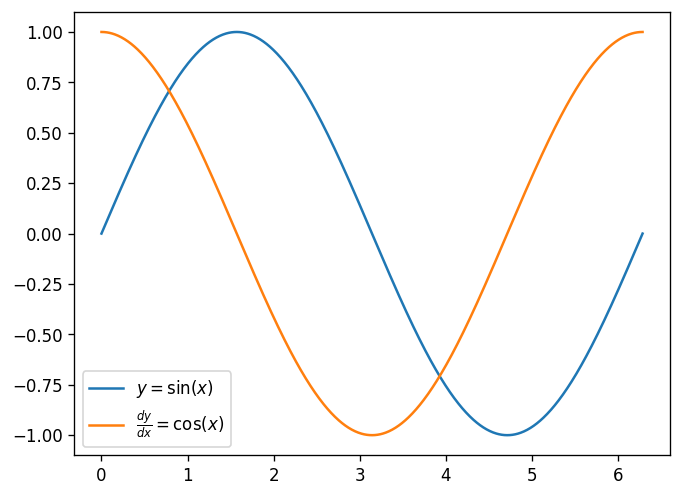

In [5]:




dy_dx = tape.gradient(y, x)  # look for dy/dx from the gradient tape


# Plot y and dy/dx
plt.figure(dpi=120)

plt.plot(x.numpy(), y.numpy(), label='$y=\\sin(x)$')
plt.plot(x.numpy(), dy_dx.numpy(), label='$\\frac{dy}{dx}=\\cos(x)$')

plt.legend()
plt.show()

---

#### 範例 (多變數偏微分): $z = (x_1+x_2+x_3+x_4)^2$

求$\frac{\partial z}{\partial x_1}|_{(x_1,x_2,x_3,x_4)=(1,1,1,1)}=?$;

$\frac{\partial z}{\partial x_2}|_{(x_1,x_2,x_3,x_4)=(1,1,1,1)}=?$;

$\frac{\partial z}{\partial x_3}|_{(x_1,x_2,x_3,x_4)=(1,1,1,1)}=?$;

$\frac{\partial z}{\partial x_4}|_{(x_1,x_2,x_3,x_4)=(1,1,1,1)}=?$

Let $u = (x_1 + x_2 + x_3 + x_4)$. We then have: $\frac{\partial z}{\partial x_1} = \frac{\partial z}{\partial u}\frac{\partial u}{\partial x_1}=2u$.

Therefore, $\frac{\partial z}{\partial x_1}|_{(x_1,x_2,x_3,x_4)=(1,1,1,1)}=2(x_1 + x_2 + x_3 + x_4)|_{(x_1,x_2,x_3,x_4)=(1,1,1,1)}=8$.

In [9]:
x = tf.ones((2, 2))
x

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[1., 1.],
       [1., 1.]], dtype=float32)>

In [10]:
with tf.GradientTape() as tape:
    tape.watch(x)
    y = tf.reduce_sum(x)
    z = tf.square(y)
    
res = tape.gradient(z, x)
print(res.numpy())

[[8. 8.]
 [8. 8.]]


[回索引](#00)

# <a name=02> 2. 資料型別: ```Variable``` and  ```constant``` </a>

### 2.1

In [11]:
a = tf.constant([1,1,1])

print(id(a))

a = a + [1,1,1]

print(id(a))

2667545405824
2668238177664


In [12]:
a = tf.Variable([1,1,1])
print(id(a))

a.assign([2,2,2])
print(id(a))

2667545884464
2667545884464


---

### 2.2

In [13]:
tf.ones((2, 2))

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[1., 1.],
       [1., 1.]], dtype=float32)>

In [14]:
x = tf.Variable(tf.ones((2, 2)))

with tf.GradientTape() as tape:
    # tape.watch(x)
    y = tf.reduce_sum(x)
    z = tf.square(y)

res = tape.gradient(z, x)
print(res.numpy())

[[8. 8.]
 [8. 8.]]


---

問: ```Variable``` 和```constant```的差異是？

答: ...

[回索引](#00)

# <a name=03> 3. 線性迴歸 </a>

以下定義兩個Class:

* ```DataSequence```: 用來拋出批次資料。
* ```LinearRegression```: 線性迴歸演算法實作。

In [21]:
from collections.abc import Mapping

In [22]:
class DataSequence(Mapping):
    """此方法負責批次性的拋出資料給機器學習的演算法做訓練。
    bs: 也就是batch size, 定義為每批資料的大小。
    """

    def __init__(self, x, y, batch_size, shuffle=True) -> None:
        self.x = x
        self.y = y
        self.bs = batch_size
        self.shuffle = shuffle

        assert len(self.x) == len(self.y)

        self.indices = np.arange(len(self))

    def __iter__(self):
        while True:
            if self.shuffle==True:
                np.random.shuffle(self.indices)

            for j in self.indices:
                yield self[j]

    def __len__(self) -> int:
        return len(self.x) // self.bs  # number of batches

    def __getitem__(
        self,
        j,
    ) -> tuple[npt.NDArray[np.float32], npt.NDArray[np.float32]]:

        x_batch = self.x[self.bs*j:self.bs*(j+1), :]
        y_batch = self.y[self.bs*j:self.bs*(j+1)]
    
        return x_batch.astype(np.float32), y_batch.astype(np.float32)

In [23]:
x = np.random.normal(0, 1, (1000, 3)).astype(np.float32)
y = np.random.randint(size=1000, low=0, high=3)

print(x.shape, y.shape)

(1000, 3) (1000,)


In [24]:
ds = DataSequence(x, y, batch_size=8)

In [25]:
for x_batch, y_batch in ds:
    print(x_batch.shape, y_batch.shape)
    break

(8, 3) (8,)


In [32]:
class LinearRegression:
    """此類別處理線性回歸 (+L1正規項)。
    """

    def __init__(self, num_features: int) -> None:

        # 將權重初始化
        self.W = tf.Variable(
            tf.random.normal((num_features,1), dtype=np.float32)
            )  # shape=[num_features, 1]
        self.b = tf.Variable(
            tf.random.normal((1,), dtype=np.float32)
            )

    def __call__(self, x) -> tf.Tensor:
        """輸入x, 利用當前的權重參數(W和b)來預測y。
        """
        # x: shape= [num_samples, num_features]
        # w: shape= [num_features, 1]
        #   tf.matmul(x, self.W): shape= [num_samples, 1]
        y_pred = tf.matmul(x, self.W) + self.b
        return tf.squeeze(y_pred) # [num_samples, 1] -> [num_samples,]

    def _mean_square_error_loss(self, y_true, y_pred) -> tf.Tensor:
        """此為Mean Square Error Loss + L1規範項。
        註：參數C越大，則規範項強度越小。
        """
        return tf.reduce_mean((y_true - y_pred)**2, keepdims=False)
        # y_true: [num_samples,]
        # y_pred: [num_samples,]
        #   tf.reduce_mean((y_true - y_pred)**2, keepdims=False): [num_samples,] -> [1,] -> scalar

    def _sgd_update_weights(self, grad_W, grad_b, lr) -> None:
        """使用Mini-batch Gradient Descent來做權重更新。
        """
        self.W.assign_sub(lr * grad_W, name="update_W")  # w:= w - lr * grad_w
        self.b.assign_sub(lr * grad_b, name="update_b")  # b:= b - lr * grad_b

    def fit(
        self,
        x: npt.NDArray[np.float32],
        y: npt.NDArray[np.float32],
        batch_size: int,
        C: float,
        num_epochs: int,
        lr: float = 0.001,
        info_epoch: int = 1,
        verbose: bool = True,
    ) -> tf.Tensor:
        """以批次更新方式，尋找最適回歸權重。

        Args:
            x (shape=[num_samples, num_features]): Training samples (feature columns).
            y (shape=[num_samples,]): Training samples (label).
            batch_size: Batch size of the training samples.
            C: Inverse of the strength of the regularization term.
            num_epochs: Number of training epochs.
            lr: Learning rate.
            info_epoch: If `verbose=True`, print information every `info_epoch`.
            verbose: Whether to print information.

        Returns:
            The training loss (a scalar value) after training is finished.
        """

        # 取得用於產生批次資料的generator
        data_generator = DataSequence(x, y, batch_size)

        # 開始最小化Loss (藉由更新 W, b)
        for epoch in range(num_epochs):
            for idx, (x, y_true) in zip(range(len(data_generator)),
                                        data_generator):
                with tf.GradientTape() as tape:
                    # ################################################
                    # 實作
                    #  1. 正向傳遞 (forward propagation), 得到預測y
                    y_pred = self(x) # [num_samples,]

                    #  2. 有了真實y和預測y -> 可以計算Loss
                    loss = self._mean_square_error_loss(y_true, y_pred)

                    #  3. Loss項再添加L1或L2懲罰項
                    # ################################################
                    # loss += ???
                    loss += (1. / C) * tf.reduce_sum(tf.abs(self.W))

                grad_W, grad_b = tape.gradient(loss, [self.W, self.b])

                self._sgd_update_weights(grad_W, grad_b, lr)  # 使用梯度下降法更新 W, b

            if(verbose and epoch % info_epoch == 0):
                loss_eval = self._mean_square_error_loss(y_true, y_pred)
                print('epoch %3i,'%epoch,'loss=',loss_eval.numpy())

        return self._mean_square_error_loss(y_true, y_pred)  # 輸出訓練後的模型Loss

[回索引](#00)

### 3.1. 準備測試資料

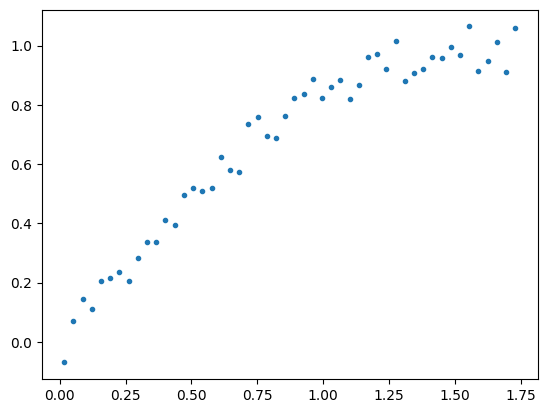

shape of x= (50, 4)
shape of y= (50,)


In [33]:
# 準備x,y
x = np.array([i*np.pi/180 for i in range(1,100,2)])
np.random.seed(100)  #Setting seed for reproducability
y = np.sin(x) + np.random.normal(0,0.05,len(x))

# 將x,y存成Pandas資料表型態
data = pd.DataFrame(np.column_stack([y,x]),columns=['y','x'])
plt.plot(data['x'],data['y'],'.')
plt.show()

# 準備x^2,x^3,x^4次方項
for i in range(2,5):
    colname = 'x_%d'%i
    data[colname] = data['x']**i
    
# 整理好資料後，將其存回Numpy矩陣
y=data.iloc[:,0].values
x=data.iloc[:,1:].values
data.head(3)

# 檢查x,y矩陣的形狀為何
print('shape of x=',x.shape)
print('shape of y=',y.shape)

[回索引](#00)

### 3.2 對資料做線性回歸

#### 3.2.1. L1規範項可忽略 

$\hat{y} = w_1 x_1 + w_2 x_2+ w_3 x_3+ w_4 x_4 + b$

epoch   0, loss= 0.6963817
epoch 100, loss= 0.11726912
epoch 200, loss= 0.009188192
epoch 300, loss= 0.0035796212
epoch 400, loss= 0.0019402448
epoch 500, loss= 0.0016186512
epoch 600, loss= 0.002208722
epoch 700, loss= 0.0015838307
epoch 800, loss= 0.0021815912
epoch 900, loss= 0.0021794727


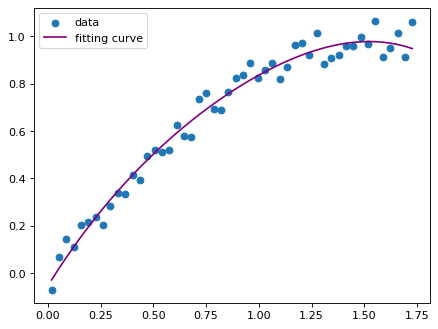

In [34]:
batch_size = 16
num_epochs = 1000
info_epoch = 100
lr = 0.02

C = 10000  # C非常大，L1規範項可忽略

verbose = True

regressor = LinearRegression(num_features=4)

final_loss = regressor.fit(
    x,
    y,
    batch_size,
    C,
    num_epochs,
    lr=lr,
    info_epoch=info_epoch,
    verbose=verbose,
)  # 回歸開始

y_pred = regressor(x.astype(np.float32)).numpy() # 以所學之權重向量，來預測所輸入的x其y值為何

plt.figure(dpi=80)
plt.scatter(x[:,0],y,label='data') # 繪製原始資料
plt.plot(x[:,0],y_pred, label='fitting curve', ls='-', color='purple') # 繪製回歸結果
plt.legend()
plt.show()

[回索引](#00)

#### 3.2.2 將C的數值減低，以增加L1規範項的影響

epoch   0, loss= 15.630885
epoch 100, loss= 0.1412727
epoch 200, loss= 0.060286082
epoch 300, loss= 0.03953991
epoch 400, loss= 0.033552222
epoch 500, loss= 0.02905825
epoch 600, loss= 0.025505684
epoch 700, loss= 0.022659088
epoch 800, loss= 0.020949341
epoch 900, loss= 0.020233845


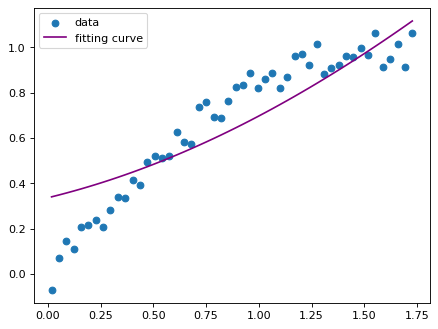

In [36]:
batch_size = 50
num_epochs = 1000
info_epoch = 100
lr = 0.02
C = 20  # C不是非常大，L1規範項不可忽略
verbose = True

regressor = LinearRegression(num_features=4)

final_loss = regressor.fit(x,
                           y,
                           batch_size,
                           C,
                           num_epochs,
                           lr=lr,
                           info_epoch=info_epoch,
                           verbose=verbose)  # 回歸開始

y_pred = regressor(x.astype(np.float32)).numpy() # 以所學之權重向量，來預測所輸入的x其y值為何

plt.figure(dpi=80)
plt.scatter(x[:,0],y,label='data') # 繪製原始資料
plt.plot(x[:,0],y_pred,label='fitting curve',ls='-',color='purple') # 繪製回歸結果
plt.legend()
plt.show()

[回索引](#00)

### 3.3. 改變C, 由1000至1, 看回歸結果如何變化

#### 3.3.1. 訓練

In [37]:
np.logspace(3, 0, 6, dtype=np.int32)

array([1000,  251,   63,   15,    3,    1])

In [40]:
batch_size = 16
num_epochs = 1000
info_epoch = 100
lr = 0.02
verbose = False

results = []
for C in np.logspace(3, 0, 6, dtype=np.int32):
    print('\n C=',C)

    regressor = LinearRegression(num_features=4)

    final_loss = regressor.fit(
        x,
        y,
        batch_size,
        C,
        num_epochs,
        lr=lr,
        info_epoch=info_epoch,
        verbose=verbose,
    )  # 回歸開始

    y_pred = regressor(x.astype(np.float32)).numpy() # 以所學之權重向量，來預測所輸入的x其y值為何

    results.append([regressor.W, regressor.b,
                    final_loss.numpy(), y_pred, C])


 C= 1000

 C= 251

 C= 63

 C= 15

 C= 3

 C= 1


[回索引](#00)

### 3.3.2. 繪圖

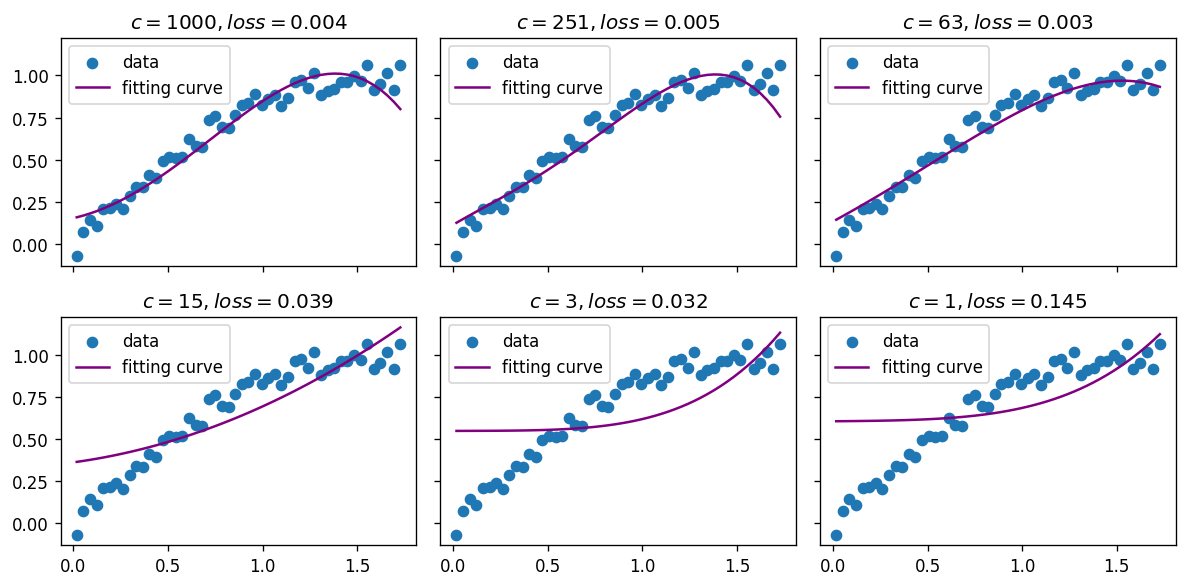

In [41]:
fig,axes=plt.subplots(2,3,sharey=True,sharex=True)
fig.set_size_inches(10,5)
fig.dpi=120
axes=axes.reshape(-1)
for idx,result in enumerate(results):
    
    loss=result[2]
    y_pred=result[3]
    C=result[4]

    axes[idx].scatter(x[:,0],y,label='data')
    axes[idx].plot(x[:,0],y_pred,label='fitting curve',ls='-',color='purple')
    axes[idx].legend()
    axes[idx].set_title('$c=%i, loss=%.3f$'%(C,loss))
plt.tight_layout()

[回索引](#00)

### 3.3.3. 將C, W, b, Loss以熱圖呈現

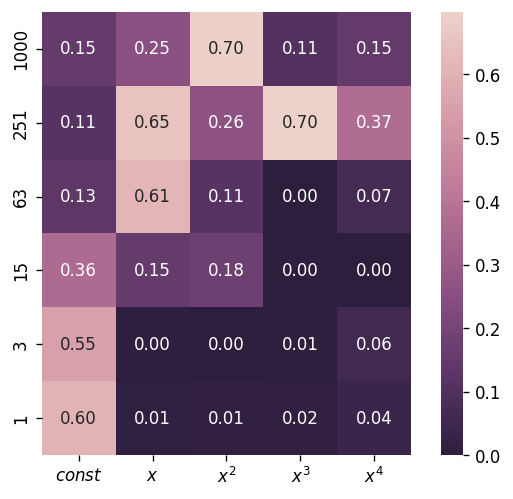

In [42]:
# 取得於不同C所訓練出的W, b，以及模型的Loss
w = np.zeros((6,5))
c = np.zeros(6,dtype=np.int32)
for idx, result in enumerate(results):

    w[idx,1:] = tf.abs(result[0]).numpy().squeeze()  # W
    w[idx,0] = tf.abs(result[1]).numpy()  # b
    c[idx] = result[4]  # C

fig,ax=plt.subplots()
fig.set_dpi(120)

# 將C, W, b, Loss以熱圖呈現
s=sns.cubehelix_palette(reverse=True, as_cmap=True)
sns.heatmap(w, xticklabels=['$const$','$x$','$x^2$','$x^3$','$x^4$'],
            yticklabels=c, cmap=s, ax=ax, annot=True, square=True, vmin=0, fmt='.2f',
            cbar_kws={"orientation": "vertical"})
plt.show()

$\hat{y} = w_1 x + w_2 x^2+ w_3 x^3+ w_4 x^4 + b$

[回索引](#00)

---

#### 練習: 將MSE (Mean-Squared Error) Loss改成 MAE (Mean Absolute Error) Loss